# Fokker Planck Equation

Consider the followig Ohrnstein Ulenbeck process
$$
dX_t = \kappa( \theta - X_t) dt + \sigma dW_t .
$$
Let $u(x,t;y,\tau)$, for $\tau \leq t$, be the transition probability density function of $X_t$, for the diffusion from $(y,\tau)$ to $(x,t)$. Then for any suitable $B\subset \mathbb{R}$, the transition pdf is such that
$$
\mathbb{P}_{y,\tau}(X_t \in B) = \int_B u(x,t;y,\tau) dx .
$$
Given the OU process, we can say that $u(x,t)$ satisfies
$$
\frac{\partial u}{\partial t} + \kappa(\theta - x)\frac{\partial u}{\partial x} - \frac12 \sigma^2 \frac{\partial^2 u}{\partial^2 x} - \kappa u =0 .
$$
The initial condition for the process at time $\tau$ is
$$
u(x,\tau) = \delta(x-y)
$$
where $\delta$ is the delta dirac function.
We have a boundary condition on the total probability, so that
$$
\int_\mathbb{D} u(x,t) dx=1 \quad\text{ for } \quad t\geq \tau 
$$
on the domain $\mathbb{D}$.


In [1]:
#include "msc_project_fokkerPlanck.hpp"

Declare some parameters on the problem

In [2]:
double kappa=1,theta=0.2,T=10,sigma=0.5;
double x0=0.,xT=1.;

The analytic solution is given by
$$ X_T \sim N\left( X_0 e^{-\kappa T} + \theta(1-e^{-\kappa T}) , \sigma^2 \frac{1-e^{-2\kappa T}}{2\kappa} \right) $$

In [3]:
boost::math::normal OU(x0*exp(-kappa*T) + theta*(1-exp(-kappa*T)),sigma*sqrt((1-exp(-2.*kappa*T))/(2.*kappa)));
    std::cout.precision(8);
    std::cout << " Solution pdf(x=" << xT << ",T="<<T<<") = " << pdf(OU,xT) << std::endl;

 Solution pdf(x=1,T=10) = 0.087223989


This gives us an analytic solution to compare against. Here we plot out the solution.

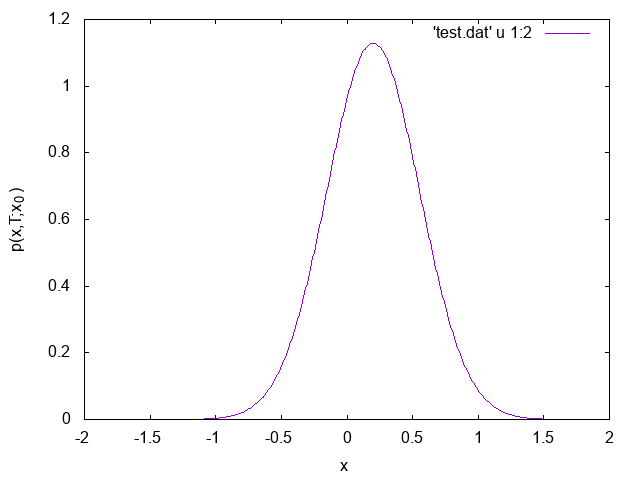

In [4]:
{
    double sd_est = sigma*sqrt((1-exp(-2.*kappa*T))/(2.*kappa));
    double xMin=theta-5*sd_est;
    double xMax=theta+5*sd_est;
    std::ofstream output("test.dat");
    int n=400;
    double dx=(xMax - xMin)/n;
    for(int j=0;j<=n;j++)
    {
        double x = xMin + j*dx;
        output << x << " " << pdf(OU,x) << std::endl;
    }
    output.close();
}

{
    std::stringstream ss("set xlabel \"x\"\n"
                    "set ylabel \"p(x,T;x_0)\"\n"
                    "p'test.dat' u 1:2 w l\n");
    MATH60082::figure = MATH60082::G.plotCommand(&ss);
}
MATH60082::figure

Next solve with finite difference.

In [5]:
double valueOld=1.;
for(int k=1;k<=10;k++)
{
    int n=4*pow(2,k);
    auto start = std::chrono::steady_clock::now(); 

    std::vector<double> X(n+1);
    std::vector<double> U(n+1);

    double sd_est = sigma*sqrt((1-exp(-2.*kappa*T))/(2.*kappa));
    double xMin=theta-10*sd_est;
    double xMax=theta+10*sd_est;

    int jMax=n;
    int iMax=n;
    double dx=(xMax-xMin)/jMax;
    double dt=T/iMax;
    int jStar0 = (x0-xMin)/dx;
    for(int j=0;j<=n;j++)
    {
        X[j] = xMin+j*dx;
        if(j==jStar0)
            U[j] = 1./dx;
        else
            U[j] = 0.;
    }

    for(int i=iMax-1;i>=0;i--)
    {
        // declare vectors for matrix equations
        std::vector<double> a(jMax+1),b(jMax+1),c(jMax+1),d(jMax+1);
        // set up matrix equations a[j]=
        a[0]=0.;b[0]=1.;c[0]=0.;d[0] = 0.;
        for(int j=1;j<=jMax-1;j++)
        {
            a[j]=0.25*(sigma*sigma/dx/dx + kappa*(theta-X[j])/dx);
            b[j]=-0.5*sigma*sigma/dx/dx + 0.5*kappa - 1./dt;
            c[j]=0.25*(sigma*sigma/dx/dx - kappa*(theta-X[j])/dx);
            d[j]=-a[j]*U[j-1]-(b[j]+2./dt)*U[j]-c[j]*U[j+1];
        }
        a[jMax]= 0.;b[jMax]=1.;c[jMax]=0.;d[jMax] = 0.;
        MATH60082::thomasSolve(a,b,c,d);
        // set old=new 
        U=d;
    }// finish looping through time steps 

    double value=MATH60082::lagrangeInterpolation(U,X,xT);
    double valueExtrap=(4.*value - valueOld)/3.;

    auto finish = std::chrono::steady_clock::now(); 
    auto elapsed = std::chrono::duration_cast<std::chrono::duration<double> >(finish - start);

    std::cout << n << " " << value << " " ;
    std::cout << valueExtrap << " ";
    std::cout << " :: ("<< elapsed.count()<< ")"<<std::endl;
    valueOld=value;

}

8 -967.82071 -1290.7609  :: (1.2773e-05)
16 -0.049316379 322.54115  :: (2.0512e-05)
32 0.050377709 0.083609071  :: (6.6978e-05)
64 0.078491037 0.087862146  :: (0.000224522)
128 0.085084717 0.087282611  :: (0.000846547)
256 0.086690961 0.087226376  :: (0.003338208)
512 0.087090843 0.087224136  :: (0.01314937)
1024 0.087190751 0.087224054  :: (0.051646478)
2048 0.087215676 0.087223984  :: (0.20462239)
4096 0.087221906 0.087223983  :: (0.82144682)


In [6]:
{
    int n=2000;
    double sd_est = sigma*sqrt((1-exp(-2.*kappa*T))/(2.*kappa));
    double xMin=theta-10*sd_est;
    double xMax=theta+10*sd_est;

    int jMax=n;
    int iMax=n;
    
    
    std::vector<double> X(jMax+1);
    std::vector<double> U(jMax+1);

    double dx=(xMax-xMin)/jMax;
    double dt=T/iMax;
    int jStar0 = (x0-xMin)/dx;
    for(int j=0;j<=n;j++)
    {
        X[j] = xMin+j*dx;
        if(j==jStar0)
            U[j] = 1./dx;
        else
            U[j] = 0.;
    }

    for(int i=iMax-1;i>=0;i--)
    {
        // declare vectors for matrix equations
        std::vector<double> a(jMax+1),b(jMax+1),c(jMax+1),d(jMax+1);
        // set up matrix equations a[j]=
        a[0]=0.;b[0]=1.;c[0]=0.;d[0] = 0.;
        for(int j=1;j<=jMax-1;j++)
        {
            a[j]=0.25*(sigma*sigma/dx/dx + kappa*(theta-X[j])/dx);
            b[j]=-0.5*sigma*sigma/dx/dx + 0.5*kappa - 1./dt;
            c[j]=0.25*(sigma*sigma/dx/dx - kappa*(theta-X[j])/dx);
            d[j]=-a[j]*U[j-1]-(b[j]+2./dt)*U[j]-c[j]*U[j+1];
        }
        a[jMax]= 0.;b[jMax]=1.;c[jMax]=0.;d[jMax] = 0.;
        MATH60082::thomasSolve(a,b,c,d);
        // set old=new 
        U=d;
    }// finish looping through time steps 

    std::ofstream output("test.dat");
    output.precision(12);
    for(int j=0;j<=jMax;j++)
    {
        double x = xMin + j*dx;
        output << x << " " << U[j] << " " << pdf(OU,X[j]) << std::endl;
    }
    output.close();
}


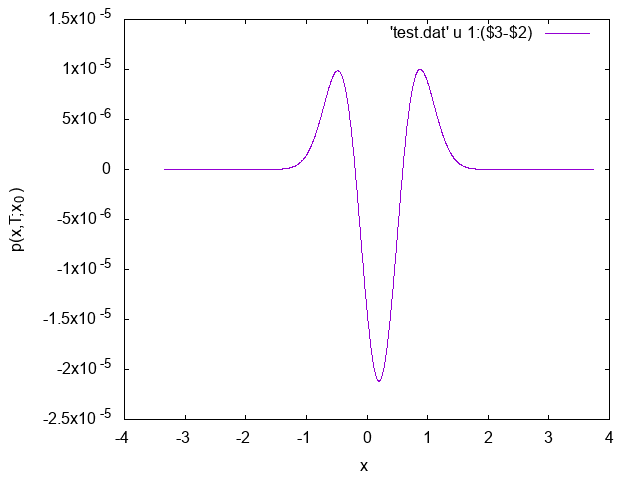

In [7]:

{
    std::stringstream ss(""
                    "set xlabel \"x\"\n"
                    "set ylabel \"p(x,T;x_0)\"\n"
                    "p'test.dat' u 1:($3-$2) w l\n");
    MATH60082::figure = MATH60082::G.plotCommand(&ss);
}
MATH60082::figure